# Comparing COVID-19 Cases with Election Results

# Todo
## Needed
- hypothesis tests
- check comments to make sure they still make sense

## Nice To Have
- perform usual tests required before regression
- describe regression results with accurate language

# ETL

### Import Utils

In [1]:
import math
import scipy
import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import pylab as py

### Import Data

Below are the `covid_confirmed_usafacts`, `npr-2016-election-data`, and `covid_county_population_usafacts` datasets used for our analysis. 

In [2]:
covid_confirmed_facts    = pd.read_csv('covid_confirmed_usafacts.csv')
election_data            = pd.read_csv('npr-2016-election-data.csv')
covid_county_population  = pd.read_csv('covid_county_population_usafacts.csv')

### Covid Cases Data Quality Check
After import we take a peek at the top few rows of our covid cases data in the `covid_confirmed_facts` dataframe. 

In [3]:
covid_confirmed_facts.head()

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2021-07-12,2021-07-13,2021-07-14,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,7306,7306,7320,7329,7341,7346,7347,7350,7365,7375
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,22337,22337,22464,22556,22642,22734,22802,22876,23032,23184
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,2367,2367,2373,2377,2386,2389,2394,2396,2411,2415
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,2704,2704,2708,2713,2719,2721,2727,2733,2747,2753


In [4]:
covid_confirmed_facts.isnull().sum()

countyFIPS     0
County Name    0
State          0
StateFIPS      0
2020-01-22     0
              ..
2021-07-17     0
2021-07-18     0
2021-07-19     0
2021-07-20     0
2021-07-21     0
Length: 551, dtype: int64

We see that the expected columns and data appear to have been imported correctly in the first output and that there are no missing values in the second. We will not need to fill in any data.

### Population Data Quality Check
Just as we had with the cases data we take a look at our population data in the `covid_county_population` dataframe.

In [5]:
covid_county_population.head()

,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869
2,1003,Baldwin County,AL,223234
3,1005,Barbour County,AL,24686
4,1007,Bibb County,AL,22394


In [6]:
covid_county_population.isnull().sum()

countyFIPS     0
County Name    0
State          0
population     0
dtype: int64

As with the case data, the columns appear to be correct and there are now missing values.

### Election Data Quality Check

Finally we check our election data in the `election_data` dataframe.

In [7]:
election_data.head()

,State,Clinton,Trump
0,AK,38,53
1,AL,35,63
2,AR,34,60
3,AZ,45,50
4,CA,62,33


In [8]:
election_data.isnull().sum()

State      0
Clinton    0
Trump      0
dtype: int64

After looking at the top few rows of each table and taking the sum of all missing values per column we can see that the data has been imported correctly. We also won't need to perform any kind of data fill since there are no missing values.

# Data Preperation 

### Aggregate Cases by State

We now drop the `County Name`, `countyFIPS` and `StateFIPS` columns from `covid_confirmed_facts` since they will not be used in our analysis (as it focuses on state only). Once these columns were dropped, we aggregate the covid case data that was by county by state. We name our new aggregated dataframe as `covid_state_cases` since these are now the number of total cummulative cases by state.

In [9]:
covid_confirmed_facts = covid_confirmed_facts.drop(columns=['County Name', 'countyFIPS', 'StateFIPS'])

covid_state_cases = covid_confirmed_facts.groupby('State').sum()

covid_state_cases.head()

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2021-07-12,2021-07-13,2021-07-14,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21
State,,,,,,,,,,,,,,,,,,,,,
AK,0,0,0,0,0,0,0,0,0,0,...,68977,68977,69189,69189,69453,69453,69453,69891,69891,70328
AL,0,0,0,0,0,0,0,0,0,0,...,555215,555215,556613,557578,558577,559478,560202,560920,562311,563943
AR,0,0,0,0,0,0,0,0,0,0,...,355460,358951,360259,361238,361238,361238,361238,365132,367007,367007
AZ,0,0,0,0,1,1,1,1,1,1,...,901562,901907,903852,904866,906117,906117,906117,909283,910437,911480
CA,0,0,0,0,2,3,3,4,4,4,...,3736534,3736534,3739625,3743242,3747897,3747897,3747897,3761997,3766720,3772006


The output shows the sum of all cases in a given state up to the date. This will work well for our state based analysis.

### Aggregate Populations by State

Similarly, for our `covid_county_population` dataframe we drop the county related columns `countyFIPS` and `County Name`. We then aggregate populations by state.

In [10]:
covid_county_population = covid_county_population.drop(columns=['countyFIPS', 'County Name'])

covid_state_population = covid_county_population.groupby('State').sum()

covid_state_population.head()

,population
State,
AK,731545
AL,4903185
AR,3017804
AZ,7278717
CA,39512223


The output shows a series with a key for each state and the population of each, we can now use this in our states analysis for per capita values. 

### Merge Data Sets

Now that all unecessary columns have been removed from our dataframes and all data is aggregated by state, we are able to merge the three dataframes into a single united data frame `pop_case_elec`. Since we currently do not know that `State` keys are in a one to one relationship between each our tables we set the validate parameter to make sure. This prevents data being dropped or duplicated without an error in our merged dataframe.

In [11]:
pop_case_elec = covid_state_population.merge(
    covid_state_cases,
    on='State',
    validate='one_to_one'
).merge(
    election_data,
    on='State',
    validate='one_to_one'
)

pop_case_elec.head()

,State,population,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,...,2021-07-14,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,Clinton,Trump
0,AK,731545,0,0,0,0,0,0,0,0,...,69189,69189,69453,69453,69453,69891,69891,70328,38,53
1,AL,4903185,0,0,0,0,0,0,0,0,...,556613,557578,558577,559478,560202,560920,562311,563943,35,63
2,AR,3017804,0,0,0,0,0,0,0,0,...,360259,361238,361238,361238,361238,365132,367007,367007,34,60
3,AZ,7278717,0,0,0,0,1,1,1,1,...,903852,904866,906117,906117,906117,909283,910437,911480,45,50
4,CA,39512223,0,0,0,0,2,3,3,4,...,3739625,3743242,3747897,3747897,3747897,3761997,3766720,3772006,62,33


The merge succeeded indicating a perfect match between data frames.

### Create Indicator clinton_win
We next create an indicator variable, `clinton_win`, which is a boolean value true only if clinton received a greater percentage of votes and thus won the election. This may prove interesting if there is a stronger correlation in states where clinton or trump won than their actual percentage of votes. Along with python convention we rename columns that are not in snake case to match.


In [12]:
pop_case_elec['clinton_win'] = pop_case_elec['Clinton'] > pop_case_elec['Trump']

pop_case_elec = pop_case_elec.rename( columns={ 'State':'state', 'Clinton':'clinton', 'Trump':'trump' } )

pop_case_elec.head()

,state,population,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,...,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21,clinton,trump,clinton_win
0,AK,731545,0,0,0,0,0,0,0,0,...,69189,69453,69453,69453,69891,69891,70328,38,53,False
1,AL,4903185,0,0,0,0,0,0,0,0,...,557578,558577,559478,560202,560920,562311,563943,35,63,False
2,AR,3017804,0,0,0,0,0,0,0,0,...,361238,361238,361238,361238,365132,367007,367007,34,60,False
3,AZ,7278717,0,0,0,0,1,1,1,1,...,904866,906117,906117,906117,909283,910437,911480,45,50,False
4,CA,39512223,0,0,0,0,2,3,3,4,...,3743242,3747897,3747897,3747897,3761997,3766720,3772006,62,33,True


Our indicator variable can be seen at the end of the dataframe and makes sense given the percentages left of each.

### Cases Time Series

Some of our variables of interest are the current rate of increase in cases, average rate of increase, projected max cases, and projected max cases per capita. While we already have the time series data necessary in order to model, for convenience we seperate out time series into its own `cases_ts` dataframe setting the index to the `state` column and dropping `population` as we won't need it.

In [13]:
cases_ts = pop_case_elec.loc[:, 'state':'2021-07-21']

cases_ts = cases_ts.set_index('state')

cases_ts = cases_ts.drop(columns=['population'])

cases_ts.head()

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2021-07-12,2021-07-13,2021-07-14,2021-07-15,2021-07-16,2021-07-17,2021-07-18,2021-07-19,2021-07-20,2021-07-21
state,,,,,,,,,,,,,,,,,,,,,
AK,0,0,0,0,0,0,0,0,0,0,...,68977,68977,69189,69189,69453,69453,69453,69891,69891,70328
AL,0,0,0,0,0,0,0,0,0,0,...,555215,555215,556613,557578,558577,559478,560202,560920,562311,563943
AR,0,0,0,0,0,0,0,0,0,0,...,355460,358951,360259,361238,361238,361238,361238,365132,367007,367007
AZ,0,0,0,0,1,1,1,1,1,1,...,901562,901907,903852,904866,906117,906117,906117,909283,910437,911480
CA,0,0,0,0,2,3,3,4,4,4,...,3736534,3736534,3739625,3743242,3747897,3747897,3747897,3761997,3766720,3772006


Our `cases_ts` dataframe is now much more usable containing only cases as values.

## Case Projections

### Modeling Utilities

In order to the calculate projected cases and projected cases per capita, we will need to build a model using our cases timeseries. To abstract away some of the complexity during analysis we created a function that uses the `curve_fit` method of the `scipy.optimize` module and returns everything we need for plotting and projection. It does so by fitting a the input model and returning the calculated betas then using the model with its calculated betas to find the projected dependants.

In [14]:
from scipy.optimize import curve_fit

def build_model( model, x_data, y_data ):
    found_betas = []
    covariance  = 0
    x_points    = x_data.shape[0]
    
    found_betas, covariance = curve_fit( model, x_data, y_data )
    
    x_proj = np.linspace( 0, x_points, num=x_points )
    y_proj = model( x_proj, *found_betas )
        
    return found_betas, covariance, x_proj, y_proj

Now that we have a modeling utility, we need to decide on a model to use for case projections. For simplicities sake, we begin with a logistic model. The function below implements a logistic model.

In [15]:
def logistic_model( x, beta_0, beta_1, beta_2 ):
    return beta_0 / (1 + np.exp(beta_1 * ( beta_2 - x ))) 

### Projected Max Cases Visualization

To test that our model builder is working we create a visualizaton with it. We take the massachusetts case data as `ma_cases`, provide a some arbitrary x values as `days`, and pass them to `build_model` with our logistic model.

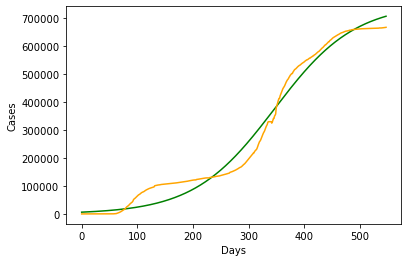

PROJECTED MAX CASES:
707421.0


In [16]:
ma_cases = cases_ts.loc['MA']

num_days = ma_cases.shape[0]
days = np.linspace( 0, num_days, num=num_days )

found_betas, covariance, x_proj, y_proj = build_model( logistic_model, days, ma_cases )


_ = sns.lineplot( x=x_proj, y=y_proj, color='Green' )
_ = sns.lineplot( x=days, y=ma_cases, color='Orange')

_ = plt.xlabel('Days')
_ = plt.ylabel('Cases')


plt.show()

print('PROJECTED MAX CASES:')
print(np.round(np.max(y_proj)))

Based off this result, we can see our logistic model (in orange) appears to be working and matches the timeseries data pretty well. It will do for our projected cases variable.

### Add Calculated Variables

The first calculated variable we will add is the `projected_max` variable. In order to add the projected maxes to our dataframe we will use a custom aggregation function. This function will take in a list of y_data and return the projected max.

In [17]:
def project_max( y_data ):
    x_len = y_data.shape[0]
    
    x_data = np.linspace( 0, x_len, num=x_len )
    
    found_betas, covariance, x_proj, y_proj = build_model( logistic_model, x_data, y_data )
    
    return np.round(np.max(y_proj))

Next we pass our function into an aggregation which results in a series of projected maxes for each state that we then merge into our main dataframe.

In [18]:
projected = cases_ts.aggregate( func=project_max, axis=1 )

pop_case_elec = pop_case_elec.merge( projected.to_frame(name='projected_max'), on='state')

<ipython-input-15-6f2958086ae9>:2: RuntimeWarning: overflow encountered in exp
  return beta_0 / (1 + np.exp(beta_1 * ( beta_2 - x )))


Using our new `projected_max` column we can calculate the projected max per capita by dividing it by the population.

In [19]:
pop_case_elec['projected_max_per_cap'] = pop_case_elec['projected_max'] / pop_case_elec['population'] 

Another variable that will need to be extrapolated from the data is the time of max increase. This will require another aggregation function. This function will return the the second beta calculated by out `build_model` function which is the time of max increase.

In [20]:
def get_max_increase( y_data ):
    x_len = y_data.shape[0]
    
    x_data = np.linspace( 0, x_len, num=x_len )
    
    found_betas, covariance, x_proj, y_proj = build_model( logistic_model, x_data, y_data )
    
    return found_betas[2]

Just as we did for the `projected_max` we use the aggregation function to create a series of the time of max increase for each state. We then join it with our main `pop_case_elec` dataframe naming it `time_max_increase`.

In [21]:
max_increase = cases_ts.aggregate( func=get_max_increase, axis=1 )

pop_case_elec = pop_case_elec.merge( max_increase.to_frame(name='time_max_increase'), on='state')

<ipython-input-15-6f2958086ae9>:2: RuntimeWarning: overflow encountered in exp
  return beta_0 / (1 + np.exp(beta_1 * ( beta_2 - x )))


Continueing on, we add the average rate of increase which can be found by dividing the current total cases on 2021-07-21 by the total number of days in the dataset as done below. We add it to the `pop_case_elec` dataframe as `avg_rate_increase`.

In [22]:
total_days = pop_case_elec.shape[1]

pop_case_elec['avg_rate_increase'] = pop_case_elec['2021-07-21'] / total_days

The calculated variable pair that we need are the total cases and total cases per capita. We know that the number of cases for the most recent day is the sum of all cases so we merely add the same column renamed as `total_cases`. Just as we did with the projected max per capita we can device this by the population to get the total cases per capita which we name `total_cases_per_cap`.

In [23]:
pop_case_elec['total_cases']   = pop_case_elec['2021-07-21']
pop_case_elec['total_cases_per_cap'] = pop_case_elec['total_cases'] / pop_case_elec['population']

Finally, we check to make sure that each of our new columns has been added correctly.

In [24]:
pop_case_elec.head()

,state,population,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,...,2021-07-21,clinton,trump,clinton_win,projected_max,projected_max_per_cap,time_max_increase,avg_rate_increase,total_cases,total_cases_per_cap
0,AK,731545,0,0,0,0,0,0,0,0,...,70328,38,53,False,66762.0,0.091262,324.094779,126.717117,70328,0.096136
1,AL,4903185,0,0,0,0,0,0,0,0,...,563943,35,63,False,563927.0,0.115012,313.146175,1016.113514,563943,0.115016
2,AR,3017804,0,0,0,0,0,0,0,0,...,367007,34,60,False,355632.0,0.117845,315.169105,661.273874,367007,0.121614
3,AZ,7278717,0,0,0,0,1,1,1,1,...,911480,45,50,False,929619.0,0.127717,325.236745,1642.306306,911480,0.125225
4,CA,39512223,0,0,0,0,2,3,3,4,...,3772006,62,33,True,3842270.0,0.097243,325.636517,6796.407207,3772006,0.095464


We can confirm that each of our new variables has been added succesfully. Now we can move on to model and statistical analysis planning.

# Model Planning

### Summary Dataframe

For our statistical analysis we begin by searching for relations and functions in the data. To do this, we create a summary dataframe that includes each of our variables of interest along with the indicator `clinton_win`. This is done by slicing them from our main `pop_case_elec` data frame, and assigning it to `sum_pop_case_elec`.

In [25]:
sum_pop_case_elec = pop_case_elec.loc[:, (
    'clinton',
    'population',
    'projected_max',
    'projected_max_per_cap',
    'time_max_increase',
    'avg_rate_increase',
    'total_cases',
    'total_cases_per_cap'
)]

sum_pop_case_elec.head()

,clinton,population,projected_max,projected_max_per_cap,time_max_increase,avg_rate_increase,total_cases,total_cases_per_cap
0,38,731545,66762.0,0.091262,324.094779,126.717117,70328,0.096136
1,35,4903185,563927.0,0.115012,313.146175,1016.113514,563943,0.115016
2,34,3017804,355632.0,0.117845,315.169105,661.273874,367007,0.121614
3,45,7278717,929619.0,0.127717,325.236745,1642.306306,911480,0.125225
4,62,39512223,3842270.0,0.097243,325.636517,6796.407207,3772006,0.095464


### Correlations
Next, in order to search for relations we use a correlation heatmap created with seaborn. The map is colored via correlation coefficients. The spectral color scheme is used to essentially assign a color to subsets of coefficients. We look for anything around *less then -.4 (red)* and *greater then .4  green*.

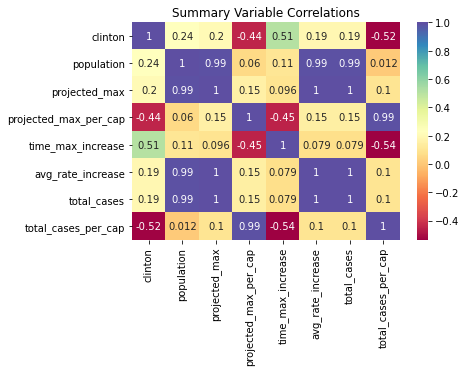

In [26]:
_ = sns.heatmap( sum_pop_case_elec.corr(), cmap='Spectral', annot=True )

_ = plt.title('Summary Variable Correlations')

plt.show()

In review of the heatmap's first row, we find a few potential relations:
- clinton and projected_max_per_cap
- clinton and time_max_increase
- clinton and total_cases_per_cap

In the next section we will test if these are indeed significant predictors of clinton's voting percentage.

# Model Building

Before performing our hypothesis tests for the correlations noted, we must check to see if the data is normally distributed. To do this we will look at histograms of each vairable.

<AxesSubplot:>

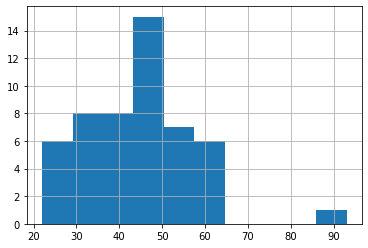

In [27]:
sum_pop_case_elec['clinton'].hist()


<AxesSubplot:>

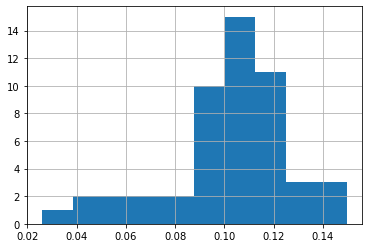

In [36]:
sum_pop_case_elec['projected_max_per_cap'].hist()


<AxesSubplot:>

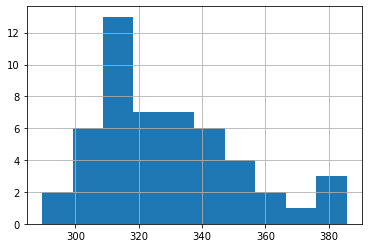

In [38]:
sum_pop_case_elec['time_max_increase'].hist()

<AxesSubplot:>

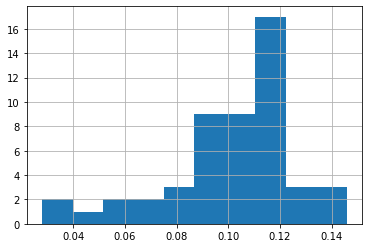

In [39]:
sum_pop_case_elec['total_cases_per_cap'].hist()

We note the following:
`clinton` contains an outlier,
`projected_max_per_cap` is skewed left,
`time_max_increase` is skewed right,
`total_cases_per` is skewed left

Taking these into consideration, we will proceed to assume the data is approximately normal for our hypothesis tests.


We conducted a 2-population difference of means test for all correlations noted above. 

H0= A clinton win has no

In [37]:
sum_pop_case_elec[['clinton','projected_max_per_cap']].describe()

ttest,pval = stats.ttest_rel(sum_pop_case_elec['clinton'],sum_pop_case_elec['projected_max_per_cap'])
print(pval)

if pval < .05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

1.3405018540523697e-30
reject null hypothesis


In [30]:
sum_pop_case_elec[['clinton','time_max_increase']].describe()

ttest,pval = stats.ttest_rel(sum_pop_case_elec['clinton'],sum_pop_case_elec['time_max_increase'])
print(pval)

if pval < .05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

7.03627890098623e-61
reject null hypothesis


In [31]:
sum_pop_case_elec[['clinton','total_cases_per_cap']].describe()

ttest,pval = stats.ttest_rel(sum_pop_case_elec['clinton'],sum_pop_case_elec['total_cases_per_cap'])
print(pval)

if pval < .05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

1.3513622264545238e-30
reject null hypothesis
